## Part 1: Kernelized Linear Regression

MSE error on linear regression on 5 features : 1006.3766905453018


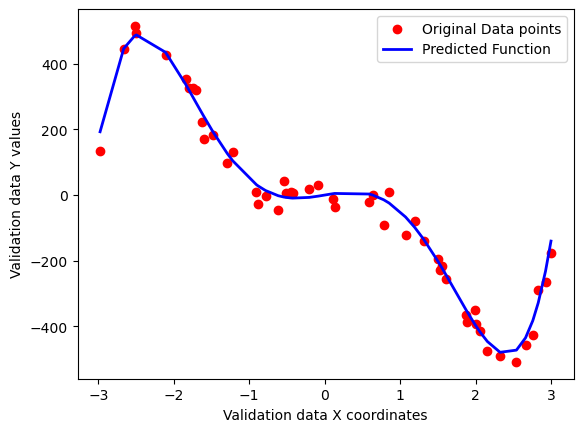

MSE error on linear regression on 1 features : 10785.26199986293


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# -----------------------------
# 1. Generate Nonlinear Training Data using a 5th order polynomial with sharp curvature
#    Here, we use: y = 10*x^5 - 100*x^3 + 40*x, which has two minima and two maxima with sharp transitions.
# -----------------------------
np.random.seed(42)

# Generate 250 evenly spaced points between -3 and 3 for a smooth curve and shuffle them
X_all = np.linspace(-3, 3, 250).reshape(-1, 1)
np.random.shuffle(X_all)

# Split into 200 training points and 50 validation points
X_train = X_all[:200]
y_train = 10 * X_train**5 - 100 * X_train**3 + 40 * X_train + np.random.randn(200, 1) * 30

X_val = X_all[200:]
X_val.sort(axis=0)
y_val = 10 * X_val**5 - 100 * X_val**3 + 40 * X_val + np.random.randn(50, 1) * 30

# -----------------------------
# 2. TO DO: Linear Regression with Manually Created Polynomial Features (degree 5)
# -----------------------------
def get_polynomial_features(X : np.ndarray, d : int) :
    if d == 1: return X 
    X_rec = get_polynomial_features(X, d-1)
    X_ret = np.concatenate((X_rec, X**d), axis=1) 
    return X_ret

# Get the features
X_train_poly = get_polynomial_features(X_train, 5)
X_val_poly = get_polynomial_features(X_val, 5)

# Train the model
Linear_regression_model = LinearRegression()
Linear_regression_model.fit(X_train_poly, y_train)

# Predict the y values on validation data
y_pred = Linear_regression_model.predict(X_val_poly)

# -----------------------------
# 3. TO DO: Plot the Data and the Fit, and Print the Training and Validation Errors (MSE)
# -----------------------------
mse_error_5D = mean_squared_error(y_val, y_pred)  
print(f"MSE error on linear regression on 5 features : {mse_error_5D}")
plt.scatter(X_val, y_val, label="Original Data points", c="red")
plt.plot(X_val, y_pred, label="Predicted Function", linewidth=2, c="blue")
plt.xlabel("Validation data X coordinates")
plt.ylabel("Validation data Y values")
plt.legend()
plt.show()

Linear_regression_model_1D = LinearRegression()
Linear_regression_model_1D.fit(X_val, y_val) 
y_pred_1D = Linear_regression_model_1D.predict(X_val)
mse_error_1D = mean_squared_error(y_val, y_pred_1D)
print(f"MSE error on linear regression on 1 features : {mse_error_1D}")


## Part 2: Logistic Regression and SoftMax Regression on MNIST 

In [24]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml("mnist_784",version=1,return_X_y=True,as_frame=False)

#make the data into usable form, normalization
y_mnist = y_mnist.astype('int')
X_mnist = X_mnist/255.0

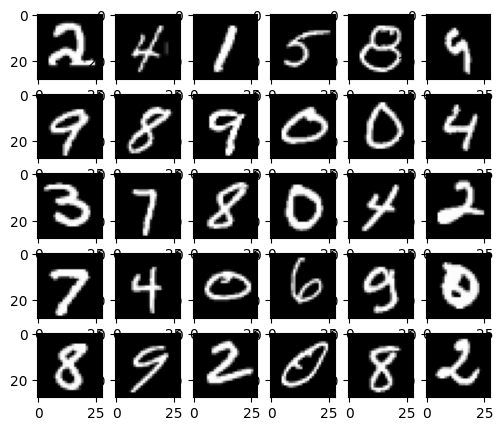

In [12]:
def display_grid(list_conn, num_col):
    num_row = int(list_conn.shape[0]/num_col)

    fig, axes = plt.subplots(num_row, num_col, figsize=(num_col,num_row))
    for i in range(num_col*num_row):
        #ax.set_title("Conn. matrix (log scale), S = "+str(i+1), fontsize=12)
        ax = axes[i%num_row, int(i/num_row)]
        full_im = ax.imshow(list_conn[i].reshape((28,28)), cmap='gray')

    #make room for the colourbar on the right and plot it
    fig.subplots_adjust(right=0.88)
    plt.show()

display_grid(X_mnist[np.random.choice(np.arange(X_mnist.shape[0]), 30)], 6)

In [13]:
def plot_curve1(pts, x_label, y_label, title):
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

  index = np.arange(1, len(pts)+1, 1)
  plt.plot(index, pts, '-b')

  plt.show()

def calculate_accuracy(y_act, y_pred):
    """Calculate accuracy given actual and predicted labels."""
    y_act = np.asarray(y_act).flatten()
    y_pred = np.asarray(y_pred).flatten()
    return np.sum(y_act == y_pred) / len(y_act)

In [14]:
def stratified_train_test_logistic(X, y, nclasses=10):
    np.random.seed(24)   #so that the same split is obtained always
    list_train = []
    list_cv = []
    list_test = []
    for label in np.unique(y):
        indices = np.where(y==label)[0]
        np.random.shuffle(indices)
        list_train += list(indices[0:int(len(indices)*6/7)])
        list_test += list(indices[int(len(indices)*6/7) : ])

    X_train_logistic = X[list_train]
    y_train_logistic = y[list_train]

    X_test_logistic = X[list_test]
    y_test_logistic = y[list_test]

    return X_train_logistic, y_train_logistic, X_test_logistic, y_test_logistic

X_train_logistic, y_train_logistic, X_test_logistic, y_test_logistic = stratified_train_test_logistic(X_mnist, y_mnist, nclasses=10)

In [27]:
print(X_train_logistic.shape, y_train_logistic.shape, X_test_logistic.shape, y_test_logistic.shape)

(59996, 784) (59996,) (10004, 784) (10004,)


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

class Logistic_Regression_mnist:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
    
    def get_accuracy(self, n : int):
        y_train_new = (self.y_train == n)*1
        y_test_new = (self.y_test == n)*1 
        model = LogisticRegression(max_iter=10000)
        model.fit(self.X_train, y_train_new)
        y_pred = model.predict(self.X_test)

        accuracy = accuracy_score(y_test_new, y_pred)*100
        print(f"Accuracy for digit {n} : {accuracy : 0.6f}%")

        return
    
    def get_accuracy_all_digits(self):
        print("Accuracies for one vs all classification for all digits : ")
        for d in range(10):
            self.get_accuracy(d)
        
        return

In [35]:
logistic_regression_model = Logistic_Regression_mnist(X_train_logistic, X_test_logistic, y_train_logistic, y_test_logistic)
logistic_regression_model.get_accuracy_all_digits()

Accuracies for one vs all classification for all digits : 
Accuracy for digit 0 :  99.170332%
Accuracy for digit 1 :  99.320272%
Accuracy for digit 2 :  98.120752%
Accuracy for digit 3 :  97.501000%
Accuracy for digit 4 :  98.360656%
Accuracy for digit 5 :  97.510996%
Accuracy for digit 6 :  98.750500%
Accuracy for digit 7 :  98.550580%
Accuracy for digit 8 :  95.791683%
Accuracy for digit 9 :  96.341463%


In [49]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

# With gradient descent
def loss_softmax(X, W, Y):
    # TO DO: Get the predicted Y_hat for the current W. dim: R^(n×k)
    Y_hat = np.dot(X, W) 
    Y_hat = softmax(Y_hat)

    # TO DO: cross-entropy loss L
    L = -np.sum(Y*np.log(Y_hat + 1e-9))
    return L

def gradient_softmax(X, W, Y):
    # TO DO: Vectorized implementation of softmax gradient
    # dim: R^(d×k)
    m = X.shape[0]
    y_pred = np.dot(X, W) 
    y_pred = softmax(y_pred)

    dZ = y_pred - Y
    grad = np.dot(X.T, dZ)/m

    return grad

def learn_params_softmax(X, Y, lr, num_epochs):
    """
    Learn softmax regression parameters using gradient descent.

    X: Feature matrix (n x d)
    Y: One-hot encoded labels (n x k)
    lr: Learning rate
    num_epochs: Number of epochs

    Returns:
    W: Learned weight matrix
    loss: List of loss values over epochs
    """
    # TO DO: Initialize weights
    W = np.random.randn(X.shape[1], Y.shape[1])

    loss = []
    for epoch in range(num_epochs):
        # TO DO: Calculate loss and append to loss list
        # TO DO: Gradient update
        Loss = loss_softmax(X, W, Y)
        loss.append(Loss)
        if(epoch%10 == 0):
            print(f"Epoch : {epoch} => Loss : {Loss}")
        grad = gradient_softmax(X, W, Y)
        W-=lr*grad 
        pass
    
    return W, loss

Epoch : 0 => Loss : 710829.5756016922
Epoch : 10 => Loss : 207521.49610169098
Epoch : 20 => Loss : 133941.44824911028
Epoch : 30 => Loss : 104928.59240729027
Epoch : 40 => Loss : 89212.70435604022
Epoch : 50 => Loss : 79257.35515845311
Epoch : 60 => Loss : 72315.78363865732
Epoch : 70 => Loss : 67155.19778283035
Epoch : 80 => Loss : 63137.38096209832
Epoch : 90 => Loss : 59897.61656995919
Epoch : 100 => Loss : 57213.54872943904
Epoch : 110 => Loss : 54942.35185978435
Epoch : 120 => Loss : 52987.8049317654
Epoch : 130 => Loss : 51282.23846428647
Epoch : 140 => Loss : 49776.40132450885
Epoch : 150 => Loss : 48433.56515119681
Epoch : 160 => Loss : 47225.79792561368
Epoch : 170 => Loss : 46131.43832001565
Epoch : 180 => Loss : 45133.36597539283
Epoch : 190 => Loss : 44217.82806493657
Epoch : 200 => Loss : 43373.63734631397
Epoch : 210 => Loss : 42591.60742920069
Epoch : 220 => Loss : 41864.13796564513
Epoch : 230 => Loss : 41184.89721378109
Epoch : 240 => Loss : 40548.57195010738
Epoch : 2

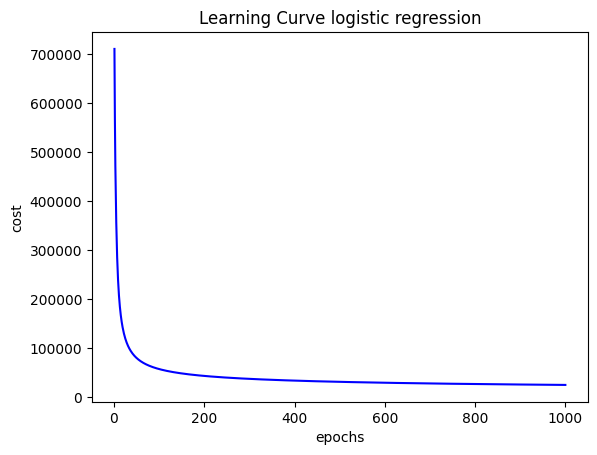

In [53]:
def train_test_softmax(X_train, y_train):
    # TO DO: Convert to one-hot encoding
    # TO DO: Create a zero matrix of shape (n_samples, n_classes)
    # TO DO: Assign 1 to the correct class indices
    m = X_train.shape[0]
    Y = np.zeros((m, 10))
    Y[np.arange(m), y_train]  = 1

    # TO DO: add 1s to X_train to allow bias in regression
    X_bias = np.ones((m, 1))
    X_train = np.concatenate((X_train, X_bias), axis=1)

    epochs = 1000
    w, loss = learn_params_softmax(X_train, Y, 1, epochs)

    plot_curve1(loss, "epochs", "cost", "Learning Curve logistic regression")
    return w

w = train_test_softmax(X_train_logistic, y_train_logistic)


Accuracy on test set by Logistic (multiclass) regression  0.89
[[9.340e+02 0.000e+00 6.000e+00 4.000e+00 2.000e+00 2.300e+01 5.000e+00
  3.000e+00 7.000e+00 3.000e+00]
 [0.000e+00 1.092e+03 5.000e+00 5.000e+00 1.000e+00 7.000e+00 1.000e+00
  2.000e+00 1.200e+01 1.000e+00]
 [9.000e+00 1.200e+01 8.700e+02 2.100e+01 1.600e+01 8.000e+00 1.700e+01
  1.500e+01 2.400e+01 7.000e+00]
 [1.000e+01 7.000e+00 2.800e+01 8.880e+02 1.000e+00 4.300e+01 3.000e+00
  1.200e+01 1.700e+01 1.200e+01]
 [2.000e+00 7.000e+00 2.000e+00 2.000e+00 8.860e+02 5.000e+00 1.400e+01
  7.000e+00 7.000e+00 4.300e+01]
 [1.300e+01 3.000e+00 6.000e+00 4.200e+01 1.200e+01 7.580e+02 1.800e+01
  3.000e+00 3.600e+01 1.100e+01]
 [1.600e+01 5.000e+00 1.200e+01 0.000e+00 1.500e+01 2.000e+01 9.010e+02
  5.000e+00 6.000e+00 3.000e+00]
 [5.000e+00 4.000e+00 1.900e+01 6.000e+00 1.100e+01 0.000e+00 0.000e+00
  9.470e+02 4.000e+00 4.600e+01]
 [5.000e+00 1.600e+01 1.300e+01 4.100e+01 1.000e+01 5.000e+01 7.000e+00
  5.000e+00 8.060e+02 2.

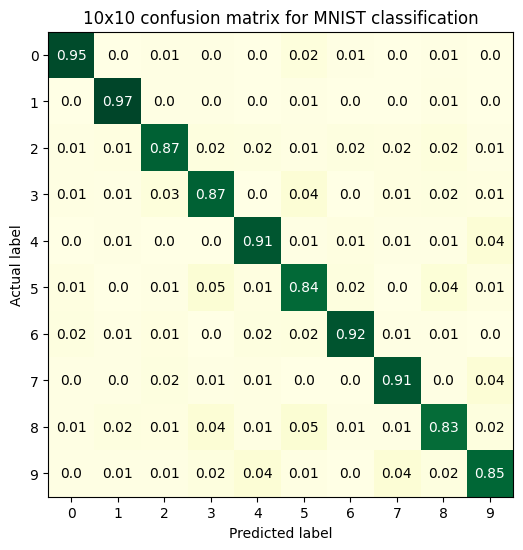

In [54]:

def display_confusion_matrix(y, y_pred, n, title_="10x10 confusion matrix for MNIST classification", labels_ = np.arange(10)):
    confusion_matrix = np.zeros((n, n))
    n_sample_per_class = np.zeros((n, 1))
    for i in range(n):
        n_sample_per_class[i, 0] = np.sum(y == i)
    for i in range(len(y)):#range(y.shape[0]):
        confusion_matrix[y[i], y_pred[i]] += 1

    print (confusion_matrix)

    confusion_matrix = confusion_matrix / n_sample_per_class

    fig, ax = plt.subplots(figsize=(6, 8))
    heatmap = ax.imshow(confusion_matrix, cmap="YlGn")

    ax.set_xticks(np.arange(n), labels=labels_)
    ax.set_yticks(np.arange(n), labels=labels_)
    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")
    plt.title(title_)
    for i in range(n):
        for j in range(n):
            if i == j:
                col = 'w'
            else:
                col = 'k'
            text = ax.text(j, i, np.round(confusion_matrix[i, j], 2), ha="center", va="center", color=col)
    return confusion_matrix

def display_test_results(W, X, y):
    # TO DO: Add 1s to X to allow bias in regression
    m = X.shape[0]
    X_bias = np.ones((m, 1))
    X_train = np.concatenate((X, X_bias), axis=1)

    # TO DO: Convert to one-hot encoding
    # TO DO: Create a zero matrix of shape (n_samples, n_classes)
    # TO DO: Assign 1 to the correct class indices
    Y = np.zeros((m, 10))
    Y[np.arange(m), y] = 1

    # TO DO: Get the probabilities for each class of the test set (X)
    # TO DO: Decide the predicted class label
    pred_y_t = softmax(np.dot(X_train, W))
    pred_y = np.argmax(pred_y_t, axis=1)

    print ()
    print("Accuracy on test set by Logistic (multiclass) regression ", np.round(calculate_accuracy(y.T, pred_y), 2))

    #display the contingency table
    display_confusion_matrix(y.T, pred_y, len(np.unique(y)))



display_test_results(w, X_test_logistic, y_test_logistic)